# k近邻法

## 距离度量

In [160]:
import math
import time

In [161]:
def Distance(x, y, p=2):
    assert len(x) == len(y), 'The dims of two points don\'t match.'
    assert len(x) > 0, 'Invalid point.'
    d = 0
    for i in range(len(x)):
        d += math.pow(abs(x[i] - y[i]), p)
    d = math.pow(d, 1/p)
    return d

## 例 3.1

In [162]:
x1 = [1, 1]
x2 = [5, 1]
x3 = [4, 4]

for i in range(1, 5):
    d = {'{}'.format(point): Distance(x1, point, p=i) for point in [x2, x3]}
    print(min(zip(d.values(), d.keys())))

(4.0, '[5, 1]')
(4.0, '[5, 1]')
(3.7797631496846193, '[4, 4]')
(3.5676213450081633, '[4, 4]')


## Dataset

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter

In [164]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']

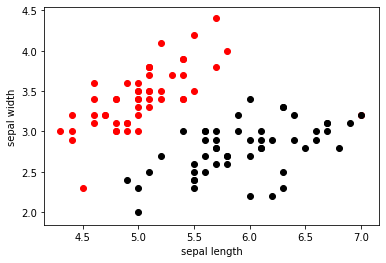

In [165]:
plt.scatter(df.loc[:50, 'sepal length'], df.loc[:50, 'sepal width'], c='red', label='0')
plt.scatter(df.loc[50:100, 'sepal length'], df.loc[50:100, 'sepal width'], c='black', label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

In [166]:
data = np.array(df.iloc[:100, [0, 1, -1]])
X, y = data[:, 0: 2], data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## KNN Model

In [167]:
class KNN:
    def __init__(self, n_neighbors=5, p=2):
        """
        n_neighbors: 临近点数量
        p: 距离度量
        """
        self.n = n_neighbors
        self.p = p
    
    def train(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, x):
        n_neighbor = []
        for i in range(len(X_train)):
            dist = np.linalg.norm(x - self.X_train[i], ord=self.p)
            n_neighbor.append((dist, self.y_train[i]))
        n_neighbor = sorted(n_neighbor, key=(lambda x: x[0]))
        n_neighbor = n_neighbor[:self.n]
        n_labels = [x[1] for x in n_neighbor]
        count = Counter(n_labels)
        label = sorted(count.items(), key=(lambda x: x[1]))[-1][0]
        
        return label

In [168]:
def accuracy_knn(model, X_test, y_test):
    right_count = 0
    for x, y in zip(X_test, y_test):
        label = model.predict(x)
        if label == y:
            right_count += 1
    return right_count / len(X_test)

In [169]:
clf = KNN()
clf.train(X_train, y_train)
t1 = time.time()
print(accuracy_knn(clf, X_test, y_test))
t2 = time.time()
print('time: %f' %(t2-t1))

1.0
time: 0.023017


## sklearn model

In [170]:
from sklearn.neighbors import KNeighborsClassifier

In [171]:
clf_skl = KNeighborsClassifier()
clf_skl.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [172]:
clf_skl.score(X_test, y_test)

1.0

## KdTree KNN

In [173]:
class KdNode:
    def __init__(self, data, split_dim, depth, left, right):
        """
        data: 节点特征向量值
        split_dim: 分割维度
        depth: 深度
        left: 左子树
        right: 右子树
        """
        self.data = data
        self.split_dim = split_dim
        self.depth = depth
        self.left = left
        self.right = right
        
class KdTree:
    def __init__(self):
        """
        feat_dim: 特征维度
        """
        self.tree = None
        self.feat_dim = 0
        self.nearest = None
    
    def buildTree(self, data, depth=0):
        """
        data: 特征向量和标签
        depth: 节点的深度
        """
        if len(data) <= 0:
            return None
        m, n = np.shape(data)
        self.feat_dim = n - 1
        split_dim = depth % self.feat_dim
        data_copy = sorted(data, key=(lambda x: x[split_dim]))
        split_index = m // 2
        
        node = KdNode(data[split_index],
                           split_dim,
                           depth,
                           self.buildTree(data_copy[:split_index], depth+1),
                           self.buildTree(data_copy[split_index+1:], depth+1))
        self.tree = node
        return node
    
    def preOrder(self, node):
        if node:
            print(node.depth, node.data)
            self.preOrder(node.left)
            self.preOrder(node.right)
    
    def search(self, x, k):
        """
        KdTree搜索
        x: 点的特征向量
        k: 邻近点个数
        """
        nearest = []
        for i in range(k):
            nearest.append([-1, None])
        self.nearest = np.array(nearest)
        
        def recurve(node):
            if node:
                axis = node.depth % self.feat_dim
                d_axis = x[axis] - node.data[axis]
                if d_axis > 0:
                    recurve(node.right)
                else:
                    recurve(node.left)
                
                dist = np.linalg.norm(x[0: 2] - node.data[0: 2], ord=2)
                for i, d in enumerate(self.nearest):
                    if d[0] < 0 or dist < d[0]:
                        self.nearest = np.insert(self.nearest, i, [dist, node.data[-1]], axis=0)
                        self.nearest = self.nearest[:-1]
                        break
                end_index = list(self.nearest[:, 0]).count(-1)
                if abs(d_axis) < self.nearest[-end_index-1, 0]:
                    if d_axis > 0:
                        recurve(node.left)
                    else:
                        recurve(node.right)
            
        recurve(self.tree)
        knn = self.nearest[:, 1]
        count_label = Counter(knn)
        label = sorted(count_label.items(), key=(lambda x : x[-1]))[-1][0]
        
        return label, self.nearest

In [178]:
def accuracy_kdtree(model, X_test, y_test):
    right_count = 0
    for x, y in zip(X_test, y_test):
        label, _ = model.search(x, 5)
        if label == y:
            right_count += 1
    return right_count / len(X_test)

In [179]:
train, test = train_test_split(data, test_size=0.2)
knn = KdTree()
knn.buildTree(train)
t1 = time.time()
print(accuracy_kdtree(knn, test[:, 0: 2], test[:, 2]))
t2 = time.time()
print('time: %f' %(t2-t1))

0.95
time: 0.023016


参考代码: https://github.com/fengdu78/lihang-code

python: 3.7.6